### <img src="https://www.dropbox.com/s/l93ecugg1jbtjiw/fga.png?raw=1" width="1200" height="400">

<ul>
    <li> <b>Campus UnB Gama</b> </li>
    <li> <b>Disciplina: Processamento Digital de Sinais Financeiros</b></li> 
    <li>
     Prof. Marcelino Monteiro de Andrade Dr.</li>
</ul> 
    
    Segunda (2/3) Atividade Prática Avaliativa - Algo Trading
    Entrega da Atividade 31/08/2022 
    "A não entrega na data esperada reduz em 50% na nota da avaliação"


<div id="Tópicos">
<h2>Questões</h2>
&ensp;
    <ol> 
        <li>Implemente uma estratégia de trade automático baseado em duas médias móveis. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aproveite os ativos escolhidos na primeira avaliação, considere um capital de R$\100.000,00 e as taxas envolvidas na operação.</a></li>&ensp;
        <li>Implemente uma estratégia de trade automático baseado em duas médias móveis anteriores, adicionando à aplicação o RSI ou MACD. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aproveite os ativos escolhidos na questão 1.</a></li>&ensp;
        <li>Escolha uma estratégia de trade automático de contra tendência, apresentada na Referência Palex. Utilize um período mínimo de 3 anos, otimize nos dois primeiros anos e aplique no terceiro. Aplique nos ativos escolhidos na questão 1.</a></li>&ensp;
        <li>Compare os resultados das três estratégias de trades, quanto: a) Retorno de Capital, b) Número de Trades, c) Taxa de Acertos, d) Fator de Lucro, e) Índice Sharpe e o f) retorno dos ativos avaliados na condição buy&hold e com relação ao índice bovespa.</a></li>&ensp;
        <li>Observação: caso a equipe tenha o interesse em avaliar outras estratégias de algo trading e bem vindo também!</a></li>&ensp;        
</ol>
</div>



In [12]:
%pip install yfinance
%pip install --upgrade matplotlib

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.
Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


In [13]:
import yfinance as yf
import matplotlib.pyplot as plt
import numpy as np
import math 

In [14]:
plt.rcParams['figure.figsize'] = [6,4]
plt.rcParams['figure.dpi'] = 100

In [15]:
data = yf.download(' AAPL','2016-01-01','2020-10-01')

[*********************100%***********************]  1 of 1 completed


In [16]:
def crossover_sinal(data):
    #criando sinais de compra e venda.SMA15 = MEDIA MOVEL DE 15 PERIODOS.SMA50 = MEDIA MOVEL DE 50 PERIODOS
    data['SMA15'] = data['Close'].rolling(15).mean()
    data['SMA50'] = data['Close'].rolling(50).mean()

    #diferenca periodo anterior e periodo atual
    data['Anter'] = data['SMA15'].shift(1) - data['SMA50'].shift(1)
    data['Atual'] = data['SMA15'] - data['SMA50']

    #se a anterior for negativa e a atual for positiva e um sinal de compra caso contrario e venda
    data.loc[(data['Anter']<0)&(data['Atual']>0),'Compra'] = data['Close']
    data.loc[(data['Anter']>0)&(data['Atual']<0),'Venda'] = data['Close']

    columns = ['Close','SMA15','SMA50','Compra','Venda']

    return data[columns]

In [20]:
output_df = crossover_sinal(data)
output_df.tail()


,Close,SMA15,SMA50,Compra,Venda
Date,,,,,
2020-09-24,108.220001,112.993999,111.605549,NaN,NaN
2020-09-25,112.279999,112.420666,111.920699,NaN,NaN
2020-09-28,114.959999,112.020666,112.293349,NaN,114.959999
2020-09-29,114.089996,112.105332,112.607999,NaN,NaN
2020-09-30,115.809998,112.004666,112.984199,NaN,NaN


In [18]:
#data set filtrado
filter_data = output_df.loc[(output_df.index < '2020-12-01') & (output_df.index < '2019-01-01')]

Text(0.5, 0, 'Data')

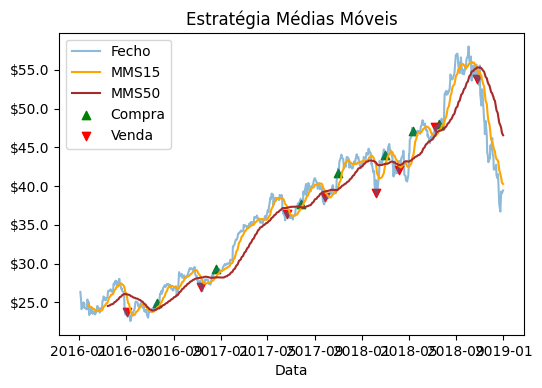

In [19]:
fig= plt.subplot()
ax = plt.subplot()

#Adiciona Informação
ax.plot(filter_data.index,filter_data['Close'],label='Fecho',alpha=0.5)
ax.plot(filter_data.index,filter_data['SMA15'],label='MMS15',color='orange')
ax.plot(filter_data.index,filter_data['SMA50'],label='MMS50',color='brown')

#Adiciona Venda e Compra
ax.scatter(filter_data.index,filter_data['Compra'],label='Compra',marker='^',color='green')
ax.scatter(filter_data.index,filter_data['Venda'],label='Venda',marker='v',color='red')

#formata

ax.legend()

#Labels adicionais
ax.yaxis.set_major_formatter('${x:}')
ax.set_title('Estratégia Médias Móveis')
ax.set_xlabel('Data')